In [1]:
import numpy as np
import numpy.random as ran
from scipy.integrate import ode
import matplotlib.pyplot as plt
import matplotlib
import time
from matplotlib import cm
import warnings
warnings.filterwarnings("always")
from matplotlib import rcParams

params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'17',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'font.family': 'sans-serif',
         'text.usetex': True}

rcParams.update(params)

class CH1species:
    
    def __init__(self,L,N,dt,init_rho,tmax,m,chi):
        self.kperiod = 4
        self.L = L
        self.N = N
        self.chi = chi
        self.m = m
        self.dt = dt
        self.dx = L/N
        self.tmax = tmax
        self.chalf = np.linspace(-L,L,int(2*N+1))
        self.cspan = np.linspace(-L + self.dx/2, L - self.dx/2, int(2*N))
        self.rho = [init_rho]
        
    def disc_laplacian(self,f):
        lap = np.zeros(len(f))
        lap[1:-1] = (f[2:] - 2*f[1:-1] + f[:-2])/self.dx**2
        lap[0] = (f[1] - f[0])/self.dx**2
        lap[-1] = (-f[-1] + f[-2])/self.dx**2
        return lap
    
    
    def velocities(self,h):
        return (h[1:]-h[:-1])/self.dx
    
    def flux(self,v,g):
        zero_vec = np.zeros(len(v))
        F = np.maximum(g[1:],zero_vec)*np.maximum(v,zero_vec) + np.maximum(g[:-1],zero_vec)*np.minimum(v,zero_vec)
        return np.concatenate([[0],F,[0]])
    
    
    def grad(self,t,x):
        x_ex = np.concatenate([[x[i] for i in range(len(x)-self.kperiod,len(x))],x,[x[i] for i in range(0,self.kperiod)]])
        h =  self.disc_laplacian(x_ex)
        vprev = - h - x_ex**(self.m - 1)*self.m/(self.m - 1)*(x_ex > 0)*self.chi
        F = self.flux(self.velocities(vprev),x_ex)
        dFdx = (F[1:]-F[:-1])/self.dx
        return dFdx[self.kperiod:len(dFdx) - self.kperiod]
    
    def solve(self):
        solODE = ode(self.grad).set_integrator('vode') 
        #solODE = ode(self.grad).set_integrator('dopri5') # for RK4 
        solODE.set_initial_value(self.rho[-1],0)
        t = 0
        tspan = [t]
        while t < self.tmax:
            print('t = %.6f'% t,end = '\r')
            t += self.dt
            solODE.integrate(t)
            self.rho.append(solODE.y)
            tspan.append(solODE.t)
        return np.array(self.rho), np.array(tspan)
    
def energy(rho,xspan,chi,m):
    dx = xspan[1] - xspan[0]
    return .5*np.array([np.sum(np.gradient(r,xspan)**2)*dx for r in rho_sol]) - chi/(m-1)*np.array([np.sum(r**m)*dx for r in rho_sol])


In [6]:
L = 3
N = 60


dt = 1e-4
m = 2.5

tmax = 1
dx = L/N

xspan = np.linspace(-L + dx/2, L - dx/2, int(2*N))

chi = 1

init_rho = (np.ones(int(2*N))*((abs(xspan) < L/4)) + 0.001*ran.uniform(-1,1,int(2*N))*((abs(xspan) < L/4)))*.1
init_rho /= np.sum(init_rho)*dx
print(np.sum(init_rho)*dx) # mass set to one

solver = CH1species(L,N,dt,init_rho,tmax,m,chi)
rho_sol, tspan = solver.solve()

1.0


10002


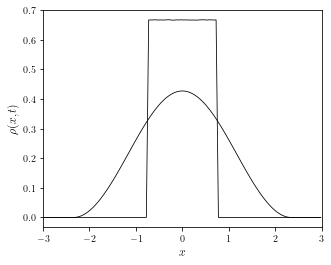

In [7]:
print(len(rho_sol))
#indexes = [100*i for i in range(10)]
indexes = [0,-1]
plt.figure(figsize = (5,4))
plt.xlim(-L,L)
#plt.ylim(0,1)
plt.xlabel('$x$')
plt.ylabel('$\\rho(x,t)$')
for i in indexes:
    plt.plot(solver.cspan,rho_sol[i],color = 'black',linewidth = .8)
plt.show()

In [ ]:
plt.plot(energy(rho_sol,xspan,chi,m))
plt.ylim(-.25,1)
plt.xscale('log')
plt.show()